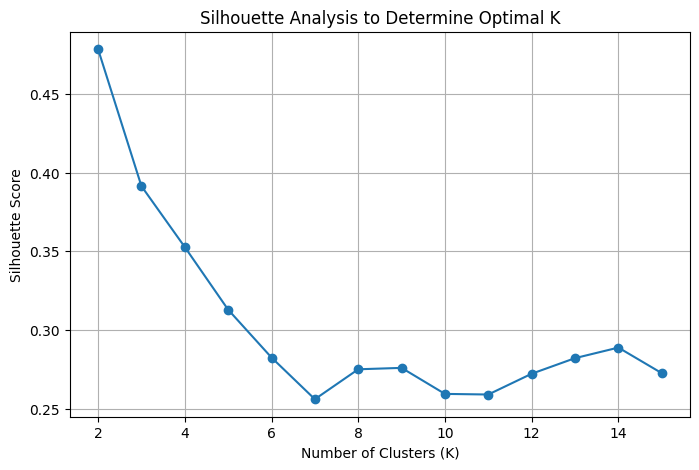

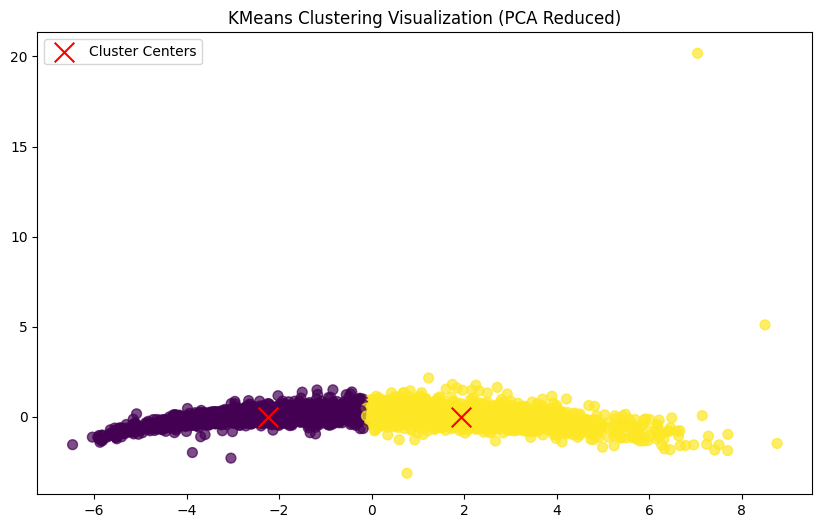

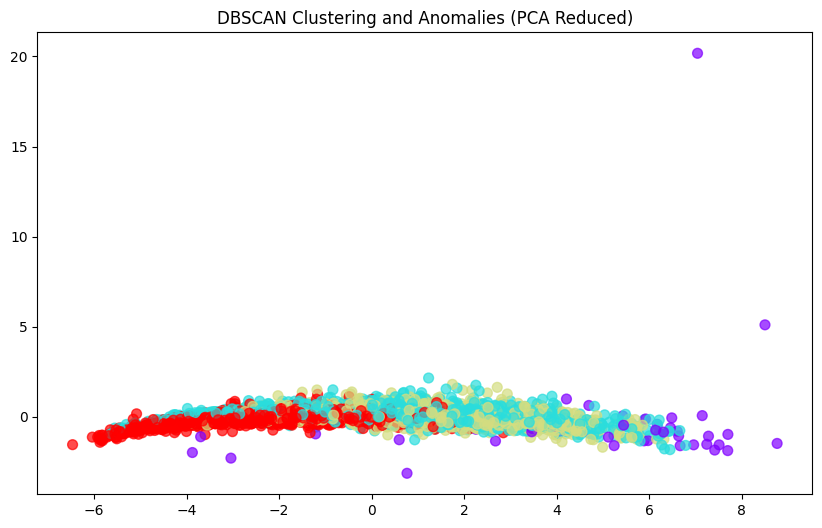

Silhouette Score (DBSCAN): 0.13
Silhouette Score (KMeans): 0.48


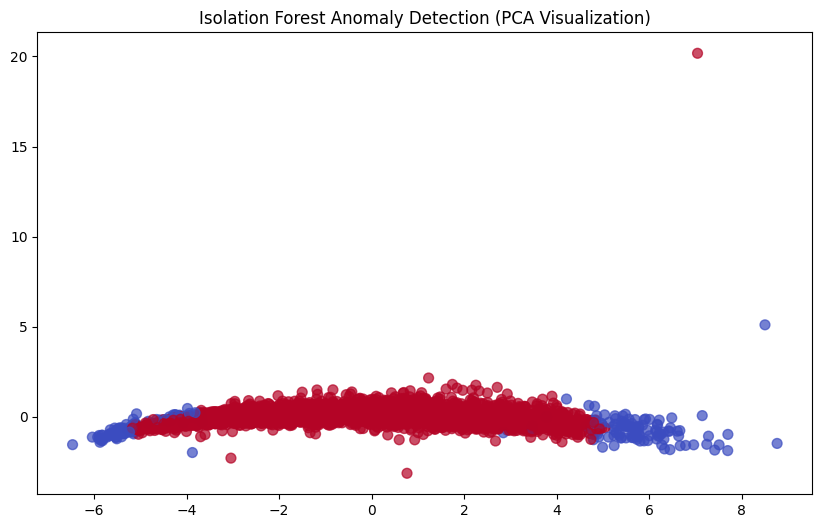


Number of Anomalies Detected by Isolation Forest: 209
     Length  Diameter  Height  WholeWeight
129   0.710     0.540   0.165       1.9590
148   0.175     0.130   0.055       0.0315
149   0.170     0.130   0.095       0.0300
163   0.725     0.560   0.210       2.1410
164   0.650     0.545   0.230       1.7520

Summary of Clustering and Anomaly Detection Results:
Optimal Number of Clusters (KMeans): 2
Silhouette Score (KMeans): 0.48
Silhouette Score (DBSCAN): 0.13
Total Anomalies Detected by Isolation Forest: 209


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the Abalone dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
columns = ["Sex", "Length", "Diameter", "Height", "WholeWeight", "ShuckedWeight", "VisceraWeight", "ShellWeight", "Rings"]

abalone_df = pd.read_csv(url, names=columns)

# Preprocessing: Encode categorical 'Sex' and scale numerical features
categorical_features = ['Sex']
numerical_features = [col for col in abalone_df.columns if col not in ['Sex', 'Rings']]

# ColumnTransformer to handle encoding and scaling in a single pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Features and target separation
X = abalone_df.drop('Rings', axis=1)
y = abalone_df['Rings']

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# KMeans Clustering - Determine Optimal K using Silhouette Score
silhouette_scores = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(X_preprocessed)
    silhouette_avg = silhouette_score(X_preprocessed, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score for different cluster sizes
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Analysis to Determine Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Identify the optimal number of clusters (K) based on the highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(X_preprocessed)

abalone_df['KMeans_Cluster'] = kmeans_labels

# Visualize Clustering with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], pca.transform(kmeans.cluster_centers_)[:, 1],
            color='red', marker='x', s=200, label='Cluster Centers')
plt.title('KMeans Clustering Visualization (PCA Reduced)')
plt.legend()
plt.show()

# DBSCAN for Density-Based Clustering and Anomaly Detection
dbscan = DBSCAN(eps=1.0, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_preprocessed)
abalone_df['DBSCAN_Cluster'] = dbscan_labels

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='rainbow', s=50, alpha=0.7)
plt.title('DBSCAN Clustering and Anomalies (PCA Reduced)')
plt.show()

# Calculate Silhouette Score for DBSCAN (excluding noise points)
if len(set(dbscan_labels)) > 1:
    filtered_points = X_preprocessed[dbscan_labels != -1]
    filtered_labels = dbscan_labels[dbscan_labels != -1]
    dbscan_silhouette = silhouette_score(filtered_points, filtered_labels)
    print(f"Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}")
else:
    print("DBSCAN resulted in a single cluster or predominantly noise.")

kmeans_silhouette = silhouette_score(X_preprocessed, kmeans_labels)
print(f"Silhouette Score (KMeans): {kmeans_silhouette:.2f}")

# Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso_forest.fit_predict(X_preprocessed)
abalone_df['IsolationForest_Anomaly'] = iso_labels

# Visualize Isolation Forest Anomalies
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iso_labels, cmap='coolwarm', s=50, alpha=0.7)
plt.title('Isolation Forest Anomaly Detection (PCA Visualization)')
plt.show()

# Print Detected Anomalies from Isolation Forest
anomalies = abalone_df[iso_labels == -1]
print(f"\nNumber of Anomalies Detected by Isolation Forest: {len(anomalies)}")
print(anomalies[['Length', 'Diameter', 'Height', 'WholeWeight']].head())

# Final Summary of Results
print("\nSummary of Clustering and Anomaly Detection Results:")
print(f"Optimal Number of Clusters (KMeans): {optimal_k}")
print(f"Silhouette Score (KMeans): {kmeans_silhouette:.2f}")
if len(set(dbscan_labels)) > 1:
    print(f"Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}")
print(f"Total Anomalies Detected by Isolation Forest: {len(anomalies)}")
